# Final Project Delivery

# Project Title: Health of the Americans' next generation

## Team: Group 10 B2

- Hailey Han (MSPPM-DA, yuehan@andrew.cmu.edu)
- Hiba Hassan (MSPPM-DA, hibah@andrew.cmu.edu)
- Kateryna Shapovalenko (MSPPM-DA, kshapova@andrew.cmu.edu)

**Outline:**
1. General picture
2. Focused view
3. Recommended actions
4. References

In [ ]:
# All libraries
import numpy as np
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from labellines import labelLines
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from joypy import joyplot
from pySankey.sankey import sankey
import plotly.graph_objects as go
import matplotlib.ticker as mtick
from string import ascii_letters

In [ ]:
df = pd.read_csv("data.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43791 entries, 0 to 43790
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            43791 non-null  int64  
 1   gender                         43791 non-null  object 
 2   grade                          43791 non-null  object 
 3   height                         43791 non-null  float64
 4   weight_real                    43791 non-null  float64
 5   seatbelt                       43791 non-null  float64
 6   drunk_driving_others           43791 non-null  float64
 7   drunk_driving_self             28442 non-null  float64
 8   texting_driving                28442 non-null  float64
 9   weapon_carry_general           43791 non-null  float64
 10  weapon_carry_school            43791 non-null  float64
 11  safety_perception_school       43791 non-null  float64
 12  fight_school                   43791 non-null 

## 1. General picture

In [ ]:
df.columns
df.reset_index(inplace=True)

In [ ]:
# Prepare the data

# Calculate the index
df['health_index'] = ((df['seatbelt'] / df['seatbelt'].mean() + # the larger value the better
                     df['drunk_driving_self'].mean() / df['drunk_driving_self'] + # the larger value the worse
                     df['cigarettes_day'].mean() / df['cigarettes_day'] +
                     df['electronic_vapor_day'].mean() / df['electronic_vapor_day'] +
                     df['alcohol'].mean() / df['alcohol'] +
                     df['marijuana_30'].mean() / df['marijuana_30'] +
                     df['cocaine'].mean() / df['cocaine'] +
                     df['unprotected_sex'].mean() / df['unprotected_sex'] +
                     df['fruit'] / df['fruit'].mean() +
                     df['green_salad'] / df['green_salad'].mean() +
                     df['breakfast'] / df['breakfast'].mean() +
                     df['TV'].mean() / df['TV'] +
                     df['computer_games'].mean() / df['computer_games'] +
                     df['PE'].mean() / df['PE'] +
                     df['sleep'].mean() / df['sleep']
                     ) * 100 / 33.618510)

# Resize the bins of categories
category = pd.cut(df.health_index,bins=[0, 50, 80, 100],labels = ['Bad (<50%)', 'Average (50-80%)', 'Good (80-100%)'])
df.insert(48, 'health_index_cat', category) # categorical

category = pd.cut(df.BMI,bins=[0, 18.5, 24.9, 100],labels=['Underweight', 'Normal', 'Overweight or Obese'])
df.insert(48, 'BMI_cat', category) # categorical

new_df = df.copy()
new_df['hopeless'] = new_df['hopeless'].astype(str)
new_df['hopeless'].replace({'1.0': 'Yes', '2.0': 'No'}, inplace = True)
df['health_index'][df['year'] == 2019].mean()

57.22724744165889

In [ ]:
# Prepare a pivot table for the first level

df1 = new_df.groupby(['health_index_cat','BMI_cat'])['index'].count().reset_index()
df1.columns = ['source','target','value']
df1

# Prepare a pivot table for the second level
df2 = new_df.groupby(['BMI_cat','gender'])['index'].count().reset_index()
df2.columns = ['source','target','value']
df2

df3 = new_df.groupby(['gender', 'hopeless'])['index'].count().reset_index()
df3.columns = ['source','target','value']
df3

# Join both level (it's like a Cartesian product)
links = pd.concat([df1, df2, df3], axis=0)
links

# Next we will find all the unique values in both the source and target columns
unique_source_target = list(pd.unique(links[['source','target']].values.ravel('k')))

# Next, we need to create a mapping dictionary. We will use a dictionary comprehension to do that.
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}
mapping_dict

# Next we need to map these values to the links dataframe that we created earlier.
links['source'] = links['source'].map(mapping_dict)
links['target'] = links['target'].map(mapping_dict)
links

# Now, we will convert this dataframe into a dictionary.
links_dict = links.to_dict(orient='list')
links_dict

links['node_color'] = ['#fb8072', '#8d8d8d', '#8d8d8d', '#8d8d8d', '#8d8d8d', '#fb8072', '#8d8d8d', '#8d8d8d', '#d9d9d9', '#fb8072', '#d9d9d9', '#d9d9d9', '#8d8d8d', '#d9d9d9', '#8d8d8d', '#d9d9d9', '#fb8072', '#fb8072', '#fb8072']
links['link_color'] = ['#fb8072', '#fb8072', '#fb8072', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#fb8072', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#fb8072', '#fb8072', '#d9d9d9', '#fb8072', '#d9d9d9', '#fb8072']

fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label = unique_source_target,
        color = links['node_color']
    ),
    link = dict(
        source= links_dict['source'],
        target = links_dict['target'],
        value = links_dict['value'],
        color = links['link_color']
    )

)

])


fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0,
                                        y=1.1,
                                        showarrow=False,
                                        text="Health index",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.28,
                                        y=1.1,
                                        showarrow=False,
                                        text="BMI level",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))


fig.add_annotation(dict(font=dict(color='black',size=15, ),
                                        x=0.62,
                                        y=1.1,
                                        showarrow=False,
                                        text="Gender",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0.9,
                                        y=1.1,
                                        showarrow=False,
                                        text="Feel hopeless",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

#fig.update_layout(title_text="Health index vs Health outcomes", font_size=10)

fig.show()

## 2. Focused view

**Daily schedule**


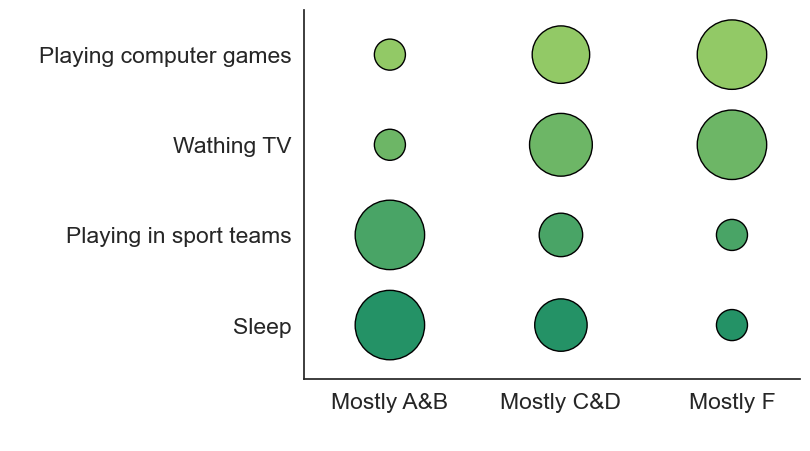

In [ ]:
# Viz 1
sns.set_palette("summer")


sleep = {'Grades': ['Mostly A&B', 'Mostly C&D','Mostly F'],
        'hour': [7.608138,7.182763,6.817337],
        'Activity':['Sleep','Sleep','Sleep']}
sleep = pd.DataFrame(sleep)

sport_team = {'Grades': ['Mostly A&B', 'Mostly C&D','Mostly F'],
        'hour': [2.031180, 1.760284, 1.674923],
        'Activity':['Playing in sport teams','Playing in sport teams','Playing in sport teams']}
sport_team = pd.DataFrame(sport_team)

TV = {'Grades': ['Mostly A&B', 'Mostly C&D','Mostly F'],
        'hour': [2.960508, 3.248973, 3.334365],
        'Activity':['Wathing TV','Wathing TV','Wathing TV']}
TV = pd.DataFrame(TV)

computer_games = {'Grades': ['Mostly A&B', 'Mostly C&D','Mostly F'],
        'hour': [3.967321, 4.293072, 4.504644],
        'Activity':['Playing computer games','Playing computer games','Playing computer games']}
computer_games = pd.DataFrame(computer_games)
## edge of bubble
## capital letter
## drop x and y name
## graph chart
sns.scatterplot(data= sleep, x="Grades", y="Activity", size="hour", legend=False, sizes=(500, 2500),edgecolor="black",linewidth=1)
sns.scatterplot(data= sport_team, x="Grades", y="Activity", size="hour", legend=False, sizes=(500, 2500),edgecolor="black",linewidth=1)
sns.scatterplot(data= TV, x="Grades", y="Activity", size="hour", legend=False, sizes=(500, 2500),edgecolor="black",linewidth=1)
sns.scatterplot(data= computer_games, x="Grades", y="Activity", size="hour", legend=False, sizes=(500, 2500),edgecolor="black",linewidth=1)
plt.ylim(-0.6, 3.5)
plt.xlim(-0.5, 2.4)
sns.despine()
sns.set(font_scale=1.5)
sns.set_style(style='white')
plt.xlabel(" ")
plt.ylabel(" ")
plt.show()

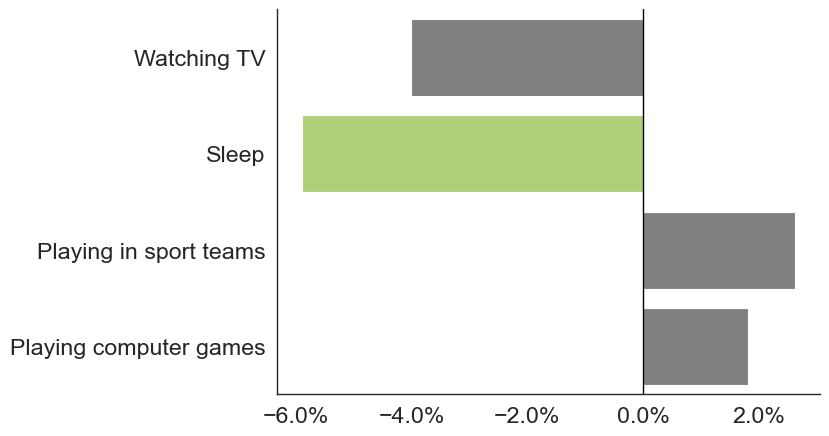

In [ ]:
# Time series

# Time series for day schedule

# Create a dataframe
dfDailySchedule = pd.DataFrame({
        'y': ['Sleep','Playing in sport teams','Watching TV','Playing computer games'],
        'x': [-5.897,2.628,-4.004,1.8163]
})

# Set the figure size
plt.figure(figsize=(7, 5))

# Reorder this data frame
dfDailySchedule = dfDailySchedule.sort_values(['y'], ascending=False).reset_index(drop=True)

# Color
a = dfDailySchedule['y']
colors = ['#b3de69' if (s == 'Sleep') else 'grey' for s in a]

a = sns.color_palette("Set2")

# Make a barplot
p=sns.barplot(x="x", y="y", data=dfDailySchedule, estimator=sum, ci=None, palette=colors)

sns.set_context("paper", font_scale=1.9)
p.set(xlabel=None, ylabel=None)
plt.axvline(x = 0 , color = 'black', linewidth=1)
sns.set_style(style='white')
sns.despine()
p.xaxis.set_major_formatter(mtick.PercentFormatter());

**Nutrition**

In [ ]:
# Prepare the data
df_new = df[['juice', 'fruit', 'green_salad', 'potato', 'carrots', 'other_vegetables', 'milk', 'year']]
df_new['juice1'] = 'juice'
df_new['fruit1'] = 'fruit'
df_new['green_salad1'] = 'green_salad'
df_new['potato1'] = 'potato'
df_new['carrots1'] = 'carrots'
df_new['other_vegetables1'] = 'other_vegetables'
df_new['milk1'] = 'milk'

juice = df_new[['juice', 'juice1', 'year']]
juice.rename(columns = {'juice':'value',
                         'juice1':'name'}, inplace = True)

fruit = df_new[['fruit', 'fruit1', 'year']]
fruit.rename(columns = {'fruit':'value',
                         'fruit1':'name'}, inplace = True)

green_salad = df_new[['green_salad', 'green_salad1', 'year']]
green_salad.rename(columns = {'green_salad':'value',
                         'green_salad1':'name'}, inplace = True)

potato = df_new[['potato', 'potato1', 'year']]
potato.rename(columns = {'potato':'value',
                         'potato1':'name'}, inplace = True)

carrots = df_new[['carrots', 'carrots1', 'year']]
carrots.rename(columns = {'carrots':'value',
                         'carrots1':'name'}, inplace = True)

other_vegetables = df_new[['other_vegetables', 'other_vegetables1', 'year']]
other_vegetables.rename(columns = {'other_vegetables':'value',
                         'other_vegetables1':'name'}, inplace = True)

milk = df_new[['milk', 'milk1', 'year']]
milk.rename(columns = {'milk':'value',
                         'milk1':'name'}, inplace = True)

concat = pd.concat([juice, fruit, green_salad, potato, carrots, other_vegetables, milk])
concat

C:\Users\Kate Shapovalenko\AppData\Local\Temp\ipykernel_30284\2178366701.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Kate Shapovalenko\AppData\Local\Temp\ipykernel_30284\2178366701.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Kate Shapovalenko\AppData\Local\Temp\ipykernel_30284\2178366701.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,value,name,year
0,2.0,juice,2019
1,2.0,juice,2019
2,1.0,juice,2019
3,2.0,juice,2019
4,4.0,juice,2019
...,...,...,...
43786,3.0,milk,1999
43787,1.0,milk,1999
43788,5.0,milk,1999
43789,6.0,milk,1999


In [ ]:
# Brief summary to double check the logic
concat_1999 = concat[concat['year'] == 1999]
concat_2017 = concat[concat['year'] == 2017]
concat_2019 = concat[concat['year'] == 2019]
data=concat.pivot_table(index=['name'], columns='year', values='value').reset_index()
data

year,name,1999,2017,2019
0,carrots,1.667991,1.700711,1.752650
1,fruit,2.889374,3.138435,3.103458
2,green_salad,2.005798,1.972841,1.973605
3,juice,3.159815,2.562817,2.342765
4,milk,3.277347,2.795530,2.747240
5,other_vegetables,2.628054,2.657027,2.703078
6,potato,2.045410,1.970200,1.950866


<Figure size 640x480 with 0 Axes>

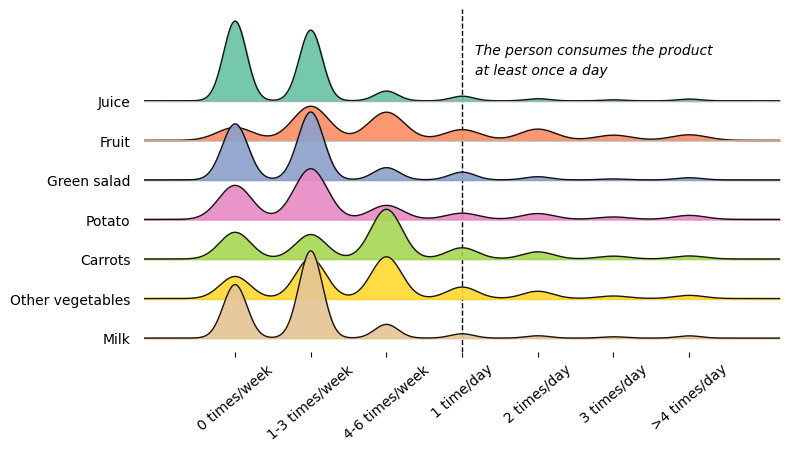

In [ ]:
# Draw the plot
concat_2019 = concat[concat['year'] == 2019]

a = sns.color_palette("Set2")
labels_y = ['Juice', 'Fruit', 'Green salad', 'Potato', 'Carrots', 'Other vegetables', 'Milk']

plt.figure()

ax, fig = joyplot(
    data=concat_2019[['value', 'name']],
    by='name',
    column=['value'],
    color=a,
    legend=False,
    alpha=0.9,
    figsize=(8, 4),
    labels=labels_y,
    grid="y", linewidth=1
    )

x = [1, 2, 3, 4, 5, 6, 7]
labels = ['0 times/week', '1-3 times/week', '4-6 times/week', '1 time/day', '2 times/day', '3 times/day', '>4 times/day']
plt.xticks(x, labels, rotation = 40, size = 10)

# Add a vertical line for a specific consumption level
plt.axvline(x = 4, linestyle = 'dashed' , color = 'black', linewidth=1)
ax.text(0.60, 0.85, 'The person consumes the product', color='black', style='italic', size = 10)
ax.text(0.60, 0.80, 'at least once a day', color='black', style='italic', size = 10)

#plt.xlabel("Average weekly consumption of selected products", fontsize=10, weight="bold")
#plt.title('Average weekly consumption of natural products by American high school students (2019)', fontsize=10, weight="bold")
plt.show()

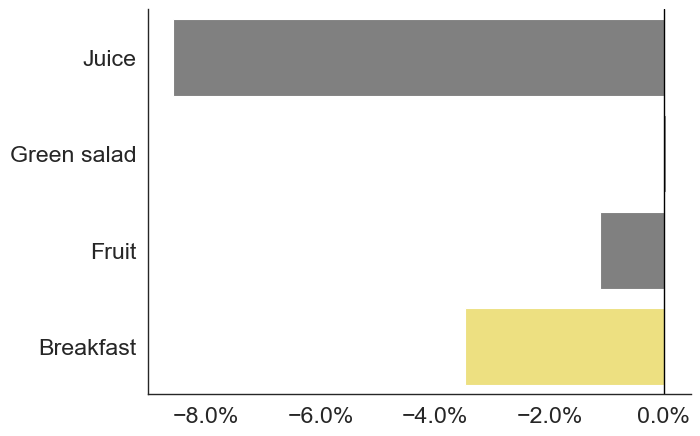

In [ ]:
# Time series

# Time series for Nuitrition

# Create a dataframe
dfNuitrition = pd.DataFrame({
        'y': ['Juice','Fruit','Green salad','Breakfast'],
        'x': [-8.5863,-1.1145,0.0387,-3.4726]
})

# Set the figure size
plt.figure(figsize=(7, 5))

# Reorder this data frame
dfNuitrition = dfNuitrition.sort_values(['y'], ascending=False).reset_index(drop=True)

# Color
a = dfNuitrition['y']
colors = ['#ffed6f' if (s == 'Breakfast') else 'grey' for s in a]

a = sns.color_palette("Set2")

# Make a barplot
p=sns.barplot(x="x", y="y", data=dfNuitrition, estimator=sum, ci=None, palette=colors)

sns.set_context("paper", font_scale=1.9)
p.set(xlabel=None, ylabel=None)
plt.axvline(x = 0 , color = 'black', linewidth=1)
sns.set_style(style='white')
sns.despine()
p.xaxis.set_major_formatter(mtick.PercentFormatter());

**Life-threatening activities**

C:\Users\Kate Shapovalenko\AppData\Local\Temp\ipykernel_30284\436696687.py:2: DtypeWarning:

Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.



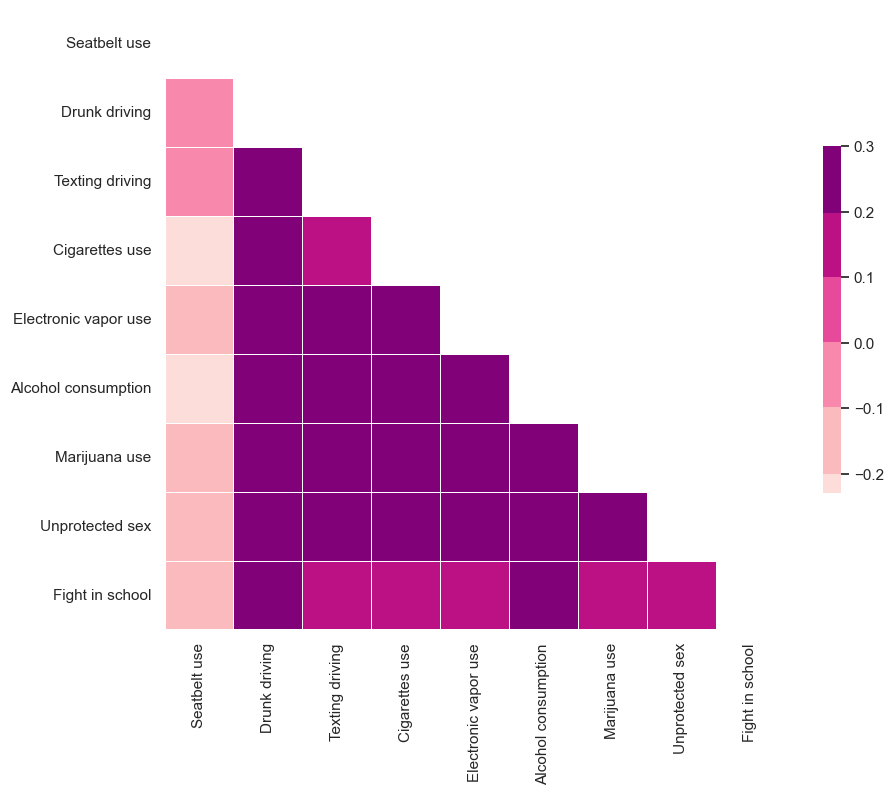

In [ ]:
# Viz 3
df = pd.read_csv("data.csv")

a = sns.color_palette("RdPu")

DFLifeThreatening=df[['seatbelt', 'drunk_driving_self', 'texting_driving', 'cigarettes_day', 'electronic_vapor_day',
                      'alcohol', 'marijuana_30', 'unprotected_sex', 'fight_school']].copy()

DFLifeThreatening.rename(columns={'alcohol':'Alcohol consumption','marijuana_30':'Marijuana use','cigarettes_day':'Cigarettes use','electronic_vapor_day':'Electronic vapor use',
                      'cocaine':'Cocaine use','drunk_driving_self':'Drunk driving','texting_driving':'Texting driving','seatbelt':'Seatbelt use',
                      'fight_school':'Fight in school', 'unprotected_sex':'Unprotected sex'},inplace = True)

sns.set_theme(style="white")

# Compute the correlation matrix
corr = DFLifeThreatening.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=a, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Rotation = 90
plt.xticks(rotation = 90)

# Change the font size to 1.5
plt.show()


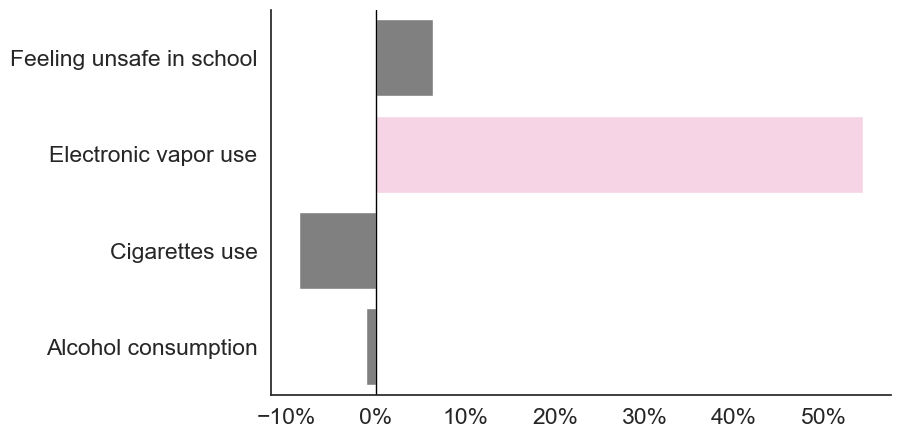

In [ ]:
# Time series

# Time series for Life Threatening

# Create a dataframe
dfLifethreatening = pd.DataFrame({
        'y': ['Alcohol consumption', 'Cigarettes use','Electronic vapor use','Feeling unsafe in school'],
        'x': [-1.1323,-8.6057,54.3466,6.3274]
})

# Set the figure size
plt.figure(figsize=(8, 5))

# Reorder this data frame
dfLifethreatening = dfLifethreatening.sort_values(['y'], ascending=False).reset_index(drop=True)

# Color
a = dfLifethreatening['y']
colors = ['#fccde5' if (s == 'Electronic vapor use') else 'grey' for s in a]

a = sns.color_palette("Set2")

# Make a barplot
p=sns.barplot(x="x", y="y", data=dfLifethreatening, estimator=sum, ci=None, palette=colors)

sns.set_context("paper", font_scale=1.9)
p.set(xlabel=None, ylabel=None)
plt.axvline(x = 0 , color = 'black', linewidth=1)
sns.set_style(style='white')
sns.despine()
p.xaxis.set_major_formatter(mtick.PercentFormatter());

## 3. Recommended actions

1. Prioritize sport at school
2. Offer a balanced breakfast at school
3. Ban vapor products (i.e., make them illegal to sell for people under 18)

## 4. References

**Resources that have been used:**
- Lecture 1-9 Slides
- Lecture 3-5 Jupyter Notebook
- Lab 1-3 solution
- Split-apply-combine cheetsheet
- https://www.cdc.gov/healthyyouth/data/yrbs/data.htm
- https://datatofish.com/how-to-connect-python-to-ms-access-database-using-pyodbc/
- https://pythoninoffice.com/python-ms-access-database-pyodbc/
- https://medium.com/nightingale/how-to-use-storytelling-conventions-to-create-better-visualizations-45177ae517ba
- https://seaborn.pydata.org/examples/heat_scatter.html
- https://seaborn.pydata.org/examples/many_pairwise_correlations.html
- https://seaborn.pydata.org/examples/scatter_bubbles.html
- https://seaborn.pydata.org/examples/scatterplot_categorical.html
- https://seaborn.pydata.org/examples/scatterplot_sizes.html
- https://seaborn.pydata.org/examples/spreadsheet_heatmap.html
- https://plotly.com/python/
- https://plotly.com/python/parallel-categories-diagram/
- https://www.javatpoint.com/data-visualization-tools
- https://www.data-to-viz.com/graph/stackedarea.html
- https://datavizcatalogue.com/
- https://datavizproject.com/
- https://www.data-to-viz.com/
- https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052
- https://stackoverflow.com/questions/59466109/how-to-get-x-axis-labels-in-multiple-line-in-matplotlib
- https://colorbrewer2.org/#type=sequential&scheme=YlGnBu&n=9
- https://lifewithdata.com/2022/08/29/how-to-create-a-sankey-diagram-in-plotly-python/
- https://github.com/vinsburg/alluvial_diagram
- https://github.com/anazalea/pySankey
- Out color palette: https://loading.io/color/feature/Set3-12/

Thank you for reading our material. Please feel free to contact our team for additional questions.